In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install d2l==0.17.6

In [ ]:
!pip install "mxnet<2.0.0"

In [ ]:
!pip install autogluon

In [ ]:
import os
path = '/content/drive/MyDrive'
os.chdir(path)

!source venv_d2l/bin/activate

path = '/content/drive/MyDrive/d2l-zh'
os.chdir(path)

可以的，之前一直没空整理代码，简单说下思路吧。
我自己看房屋价格都是附近房子的价格、周边配套、出售时间、面积等等因素。

附近价格采用zip的价格中位数
周边配套只有学校分数和距离
出售时间很奇怪，数据没有提供，只知道都是2020-2021，不过可以预估出来
面积方面每平价格是个比较常用的指标
再说说我发现的一些有趣的内容

邮编理论上应该用分类编码，但用顺序编码效果会更好，我猜是因为越高的邮编代表的地区越新，而老城区价格一般都比较高
summary中有数据泄露，大概可以提升0.01的效果，能比automl分数好就是这个原因。大概10%的数据中包含了sold price与卖出月份，从日期可以看出数据是按卖出时间排序的。至于为什么会有这个情况，是因为数据是从房屋中介网站zillow上爬来的，summary在卖出后又更新了
当listed price和sold price偏离很大的时候，一般是因为数据真的出错或者listed price太过久远。前者只能删掉数据，后者可以按邮编算出地区年平均涨幅，会有一些作用

假设特征是字符串的话，可以用one hot encoding，但是如果有100万个不同元素的话，可能就变成100万个列，内存就炸掉了。要么是用稀疏矩阵来存，要么就不该用one hot encoding。

所以例如summary和address就应该把每个词拿出来。back forwards，贴词类。

net(X)调用python的core函数，等价于forward函数了。

几乎没有不可导的函数，只不过不是处处可导。



In [ ]:
# 实战Kaggle比赛：预测房价
# 实现几个函数来方便下载数据

import hashlib
import os
import tarfile
import zipfile
import requests

# 通过字典指定预定义的数据集
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
def download(name, cache_dir=os.path.join('..', 'data')):
  """下载一个DATA_HUB中的文件，返回本地文件名"""
  # 请求下载的文件名 (name) 存在于 DATA_HUB 字典的键中。如果不存在，将引发一个断言错误，并提示文件名不存在。
  assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
  # 从 DATA_HUB 字典中获取指定名称文件的下载URL和其SHA1哈希值
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exist_ok=True)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  # 如果文件已存在于缓存目录中，通过比较SHA1哈希值来检查文件的完整性。如果哈希值匹配，意味着文件完整无误，函数返回该文件的路径，不会重新下载。
  if os.path.exists(fname):
    # 初始化SHA1哈希对象
    sha1 = hashlib.sha1()
    # 以二进制读取模式打开文件
    with open(fname, 'rb') as f:
      while True:
        # 每次从文件中读取1MB（1048576字节）的数据
        data = f.read(1048576)
        if not data:
          break
        sha1.update(data)
    # 计算完整的文件哈希值后，通过调用sha1.hexdigest()将哈希值转换为十六进制字符串，并与预定义的哈希值（sha1_hash）进行比较。
    # 如果这两个哈希值相等，说明本地文件是完整且未被篡改的，因此函数返回该文件的路径（return fname），无需重新下载。
    # 如果哈希值不匹配，意味着文件可能已损坏或已更新，需要重新下载。
    if sha1.hexdigest() == sha1_hash:
      return fname # 命中缓存
  print(f'正在从{url}下载{fname}...')
  # 其中 stream=True 允许按需下载（即边下载边存储到文件，适用于大文件），verify=True 确保进行SSL证书验证。
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

In [ ]:
def download_extract(name, folder=None):
  """下载并解压zip/tar文件"""
  fnname = download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == '.zip':
    fp = zipfile.ZipFile(fname, 'r')
  elif ext in ('.tar', '.gz'):
    fp = tarfile.open(fname, 'r')
  else:
    assert False, '只有zip/tar文件可以被解压缩'
  fp.extractall(base_dir)
  return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
  """下载DATA_HUB中的所有文件"""
  for name in DATA_HUB:
    download(name)

In [ ]:
# 使用pandas读入并处理数据

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

ModuleNotFoundError: No module named 'd2l'

In [ ]:
DATA_HUB['kaggle_house_train'] = (  #
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [ ]:
# Kaggle例子
# train_data = pd.read_csv(download('kaggle_house_train'))
# test_data = pd.read_csv(download('kaggle_house_test'))

# 实际数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
print(train_data.shape)
print(test_data.shape)

(47439, 41)
(31626, 40)


In [ ]:
# 前面4个和最后2个特征，以及相应标签（房价）
# Id不能用作训练
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id            Address  Sold Price  \
0   0        540 Pine Ln   3825000.0   
1   1     1727 W 67th St    505000.0   
2   2     28093 Pine Ave    140000.0   
3   3  10750 Braddock Dr   1775000.0   

                                             Summary         City    Zip State  
0  540 Pine Ln, Los Altos, CA 94022 is a single f...    Los Altos  94022    CA  
1  HURRY, HURRY.......Great house 3 bed and 2 bat...  Los Angeles  90047    CA  
2  'THE PERFECT CABIN TO FLIP!  Strawberry deligh...   Strawberry  95375    CA  
3  Rare 2-story Gated 5 bedroom Modern Mediterran...  Culver City  90230    CA  


In [ ]:
# 在每个样本中，第一个特征是Id，我们将其从数据集中删除
# train删除Sold Price
all_features = pd.concat((train_data.drop(train_data.columns[[0, 2]], axis=1), test_data.iloc[:, 1:]))

In [ ]:
# 将所有缺失的值替换为相应特征的平均值。通过将特征重新缩放到零均值和单位方差来 标准化 数据！！！

# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 这里是把训练集和测试集放在一起求均值和方差
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [ ]:
# 处理离散值，我们用一次独热编码替换它们 One-Hot Encoding

# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

In [ ]:
# 从pandas格式中提取NumPy格式，并将其转换为张量表示
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1, 1), dtype=torch.float32)

In [ ]:
# 训练
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net(dropout1, dropout2, first_layer):
    net = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features, first_layer),
                    nn.ReLU(),
                    nn.Dropout(dropout1),
                    nn.Linear(first_layer, first_layer),
                    nn.ReLU(),
                    nn.Dropout(dropout2),
                    nn.Linear(first_layer, 1))

    def init_weights(m):
      # Xavier
      std = (2.0/(in_features + first_layer))**0.5
      if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=std)

    net.apply(init_weights)

    return net

In [ ]:
# 我们更关心相对误差，解决这个问题的一种方法是用价格预测的对数来衡量差异

def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1

    # 通过神经网络模型net传递输入特征features，获得模型的预测输出。
    # 限制这些预测值至少为1（即设置min=1），没有上限（max=float('inf')，表示正无穷）。这意味着输出的预测值将不会小于1，但可以无限大。
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # 预测值和label都做log 然后计算rmse
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [ ]:
# 训练函数将借助Adam优化器
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法，可以理解为比较平滑的SGD，好处是对学习率没那么敏感
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [ ]:
# K折交叉验证
# 给定K，第几折，训练数据，返回对应的测试集和验证集
def get_k_fold_data(k, i, X, y):
    assert k > 1
    # 每一折的大小是样本数整除k
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    # 把它切成k项
    for j in range(k):
        # 当前这一折的大小
        idx = slice(j * fold_size, (j + 1) * fold_size)
        # 取出第j折的特征数据和目标变量
        X_part, y_part = X[idx, :], y[idx]
        # 当前第几折，就把这一折作为validation dataset
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            # 0意味着沿着第一维度进行拼接
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
# K折交叉验证
# 返回训练和验证误差的平均值
# 给定各种超参数，做一次k折交叉验证，返回平均损失和平均的验证集的损失

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size, dropout1, dropout2, first_layer):
    train_l_sum, valid_l_sum = 0, 0
    # 做k次
    for i in range(k):
        # 每一次拿到第i折的数据，包含训练集和验证机
        data = get_k_fold_data(k, i, X_train, y_train)
        # 初始化network
        net = get_net(dropout1, dropout2, first_layer)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        # 判断第一折，下面的绘图也是第一折的迭代结果
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k # 每一折的loss求和做平均

In [ ]:
# 模型选择
# 只能看到没有overfitting 不能确定好还是坏
# k, num_epochs, lr, weight_decay, batch_size, dropout1, dropout2, first_layer = 5, 100, 0.001, 0.001, 64, 0.1, 0.5, 256
k, num_epochs, lr, weight_decay, batch_size, dropout1, dropout2, first_layer = 5, 100, 0.1, 0.01, 64, 0.1, 0.1, 256
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size, dropout1, dropout2, first_layer)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

# 考虑层数更深一点

In [ ]:
# 首先，我们设置超参数的可选值
learning_rates = [0.1, 0.01, 0.001, 0.0001]
weight_decays = [0.01, 0.001, 0.0001]
batch_sizes = [64, 128, 256]
dropout1_options = [0.1, 0.5, 0.9]
dropout2_options = [0.1, 0.5, 0.9]
first_layer_options = [512, 256, 128, 64, 32, 16, 8, 4]

# 初始化变量以存储最佳的参数组合和对应的验证集损失
best_valid_rmse = float('inf')
best_params = {}

# 使用嵌套循环遍历超参数的所有组合
for lr in learning_rates:
    for weight_decay in weight_decays:
        for batch_size in batch_sizes:
            for dropout1 in dropout1_options:
                for dropout2 in dropout2_options:
                    for first_layer in first_layer_options:
                        # 调用K折交叉验证函数
                        train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                                                  weight_decay, batch_size, dropout1, dropout2, first_layer)
                        # 如果当前的验证集损失是目前为止最佳的，更新最佳损失和参数
                        if valid_l < best_valid_rmse:
                            best_valid_rmse = valid_l
                            best_params = {
                                'lr': lr,
                                'weight_decay': weight_decay,
                                'batch_size': batch_size,
                                'dropout1': dropout1,
                                'dropout2': dropout2,
                                'first_layer': first_layer
                            }
                        # 打印当前参数组合及其对应的平均训练和验证RMSE
                        print(f'lr {lr}, weight_decay {weight_decay}, batch_size {batch_size}, '
                              f'dropout1 {dropout1}, dropout2 {dropout2}, first_layer {first_layer}, '
                              f'k-fold validation: avg train log rmse: {float(train_l):f}, '
                              f'avg valid log rmse: {float(valid_l):f}')

# 打印出最佳的参数组合和对应的验证集损失
print(f'Best parameters found:\n {best_params}')
print(f'Best validation log rmse: {best_valid_rmse:f}')

折1，训练log rmse0.065619, 验证log rmse0.127778
折2，训练log rmse0.065360, 验证log rmse0.169431
折3，训练log rmse0.084130, 验证log rmse0.151310
折4，训练log rmse0.060743, 验证log rmse0.128802
折5，训练log rmse0.063687, 验证log rmse0.156850
lr 0.1, weight_decay 0.01, batch_size 64, dropout1 0.1, dropout2 0.1, first_layer 512, k-fold validation: avg train log rmse: 0.067908, avg valid log rmse: 0.146834
折1，训练log rmse0.065973, 验证log rmse0.132692
折2，训练log rmse0.066524, 验证log rmse0.161707
折3，训练log rmse0.073040, 验证log rmse0.161150
折4，训练log rmse0.089530, 验证log rmse0.144569
折5，训练log rmse0.076934, 验证log rmse0.163669
lr 0.1, weight_decay 0.01, batch_size 64, dropout1 0.1, dropout2 0.1, first_layer 256, k-fold validation: avg train log rmse: 0.074400, avg valid log rmse: 0.152757
折1，训练log rmse0.093821, 验证log rmse0.160626
折2，训练log rmse0.100389, 验证log rmse0.175307
折3，训练log rmse0.090117, 验证log rmse0.156974
折4，训练log rmse0.117230, 验证log rmse0.147467
折5，训练log rmse0.089285, 验证log rmse0.190638
lr 0.1, weight_decay 0.01, batch_size 64

In [ ]:
# 提交你的Kaggle预测

def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    # 在完整的训练集上训练一次
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162487


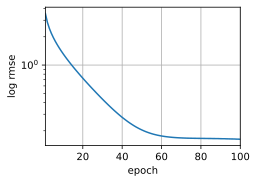

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [ ]:
# Auto ML training
from autogluon.tabular import TabularDataset, TabularPredictor
import numpy as np

train_data = TabularDataset('train.csv')
id, label = 'Id', 'Sold Price'
# 数据预处理
large_val_cols = ['Lot', 'Total interior livable area', 'Tax assessed value',
                  'Annual tax amount', 'Listed Price', 'Last Sold Price']
for c in large_val_cols + [label]:
    train_data[c] = np.log(train_data[c]+1)
predictor = TabularPredictor(label=label).fit(train_data.drop(columns=[id]))
# 更好的模型 需要GPU才跑得动
# predictor = TabularPredictor(label=label).fit(train_data.drop(columns=[id]), hyperparameters='multimodal', num_stack_levels=1, num_bag_folds=5)

In [ ]:
import pandas as pd
test_data = TabularDataset('test.csv')
preds = predictor.predict(test_data.drop(columns=[id]))
submission = pd.DataFrame({id:test_data[id], label:preds})
submission.to_csv('submission.csv', index=False)